
========== TWO-VIEW RECONSTRUCTION ==========
Using:
  /Users/eemanadnan/Documents/MS-AI/Assignments/CV Project/images_folder/IMG_4461.jpeg
  /Users/eemanadnan/Documents/MS-AI/Assignments/CV Project/images_folder/IMG_4462.jpeg
Using calibrated iPhone 14 main camera intrinsics:
[[3.266e+03 0.000e+00 2.016e+03]
 [0.000e+00 3.292e+03 1.512e+03]
 [0.000e+00 0.000e+00 1.000e+00]]

1) Detecting + Matching Features...
   Total matches after ratio test: 1591

2) Estimating Essential Matrix...
   Essential Matrix Inliers: 630

3) Recovering Correct Pose...
   ✔ Selected Valid R, t
   R:
 [[ 0.90830723 -0.04526055 -0.41584788]
 [ 0.04584921  0.99891156 -0.00857552]
 [ 0.41578339 -0.01127709  0.90939376]]
   t: [0.99340704 0.02801192 0.11116559]

4) Triangulation Stats
   Valid 3D points: 630
   Mean depth: 11.74
   Range: 8.54 → 19.46


/var/folders/3t/knrwfbfj3yv5ts631wlz1zj00000gn/T/ipykernel_31124/3957792711.py:166: RuntimeWarning: divide by zero encountered in matmul
  pts_cam2 = (R @ pts3D.T + tvec).T
/var/folders/3t/knrwfbfj3yv5ts631wlz1zj00000gn/T/ipykernel_31124/3957792711.py:166: RuntimeWarning: overflow encountered in matmul
  pts_cam2 = (R @ pts3D.T + tvec).T
/var/folders/3t/knrwfbfj3yv5ts631wlz1zj00000gn/T/ipykernel_31124/3957792711.py:166: RuntimeWarning: invalid value encountered in matmul
  pts_cam2 = (R @ pts3D.T + tvec).T


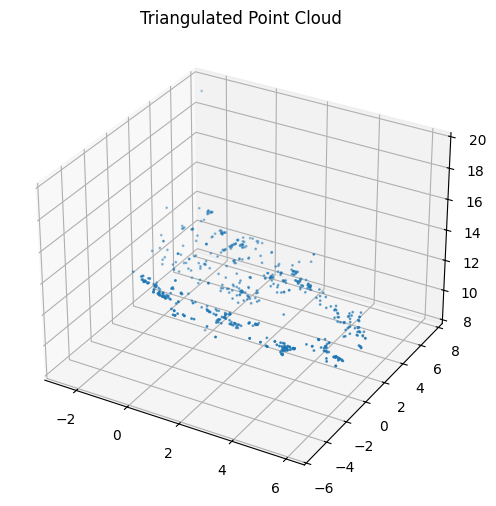

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ExifTags


# ======================================================================
# 1) Camera Intrinsics (from EXIF or fallback to calibrated iPhone 14)
# ======================================================================

def get_camera_matrix(image_path):
    img = Image.open(image_path)
    width, height = img.size

    # Try EXIF
    exif = img.getexif()
    focal_mm = None
    focal35 = None

    for tag, val in exif.items():
        decoded = ExifTags.TAGS.get(tag, tag)
        if decoded == "FocalLength":
            focal_mm = val[0] / val[1]
        if decoded == "FocalLengthIn35mmFilm":
            focal35 = val

    # If EXIF fails → use calibrated iPhone 14 Pro main camera intrinsics
    if focal_mm is None or focal35 is None:
        print("Using calibrated iPhone 14 main camera intrinsics:")
        K = np.array([
            [3266,    0, 2016],
            [   0, 3292, 1512],
            [   0,    0,    1]
        ], dtype=float)
        return K

    # physical sensor width
    sensor_width_mm = focal_mm * (36.0 / focal35)
    sensor_height_mm = sensor_width_mm * (height / width)

    fx = (focal_mm / sensor_width_mm) * width
    fy = (focal_mm / sensor_height_mm) * height

    cx = width / 2
    cy = height / 2

    K = np.array([
        [fx, 0, cx],
        [0, fy, cy],
        [0,  0,  1]
    ], dtype=float)

    print("Using EXIF intrinsics:")
    return K



# ======================================================================
# 2) Feature Detection & Matching (SIFT + ratio test)
# ======================================================================

def detect_and_match(img1_path, img2_path):
    img1 = cv2.imread(img1_path)
    img2 = cv2.imread(img2_path)

    g1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    g2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(g1, None)
    kp2, des2 = sift.detectAndCompute(g2, None)

    bf = cv2.BFMatcher(cv2.NORM_L2)
    matches_knn = bf.knnMatch(des1, des2, k=2)

    good = []
    for m, n in matches_knn:
        if m.distance < 0.7 * n.distance:
            good.append(m)

    return kp1, kp2, good, img1, img2



# ======================================================================
# 3) Essential Matrix
# ======================================================================

def estimate_E(kp1, kp2, matches, K):
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])

    E, mask = cv2.findEssentialMat(
        pts1, pts2, K,
        method=cv2.RANSAC, prob=0.999, threshold=1.0
    )

    inliers = mask.ravel() == 1
    return E, pts1[inliers], pts2[inliers]



# ======================================================================
# 4) Triangulation (clean, stable, sanitized)
# ======================================================================

def triangulate_points(pts1, pts2, K, R, t):

    # Projection matrices
    P1 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))
    P2 = K @ np.hstack((R, t))

    # Convert to homogeneous 2D
    pts1_h = cv2.convertPointsToHomogeneous(pts1).reshape(-1, 3).T
    pts2_h = cv2.convertPointsToHomogeneous(pts2).reshape(-1, 3).T

    # Triangulate
    pts4D = cv2.triangulatePoints(P1, P2, pts1_h[:2], pts2_h[:2])
    pts3D = (pts4D[:3] / pts4D[3]).T

    # ===== SANITIZATION (removes overflow & nan problems) =====
    bad = (
        np.isnan(pts3D).any(axis=1) |
        np.isinf(pts3D).any(axis=1) |
        (np.abs(pts3D) > 1e4).any(axis=1)
    )
    pts3D[bad] = np.nan

    return pts3D



# ======================================================================
# 5) Cheirality Test (stable, warning-free)
# ======================================================================

def recover_correct_pose(E, pts1, pts2, K):
    R1, R2, t = cv2.decomposeEssentialMat(E)
    t = t.reshape(3, 1)

    candidates = [
        (R1,  t),
        (R1, -t),
        (R2,  t),
        (R2, -t)
    ]

    best_R, best_t, best_pts = None, None, None
    best_count = -1

    for R, tvec in candidates:

        pts3D = triangulate_points(pts1, pts2, K, R, tvec)

        # strip bad points
        mask = ~np.isnan(pts3D).any(axis=1)
        pts3D = pts3D[mask]

        if len(pts3D) == 0:
            continue

        # depth in camera 1
        z1 = pts3D[:, 2]

        # depth in camera 2
        pts_cam2 = (R @ pts3D.T + tvec).T
        z2 = pts_cam2[:, 2]

        valid = (z1 > 0) & (z2 > 0)
        count = np.sum(valid)

        if count > best_count:
            best_count = count
            best_R = R
            best_t = tvec
            best_pts = pts3D[valid]

    return best_R, best_t, best_pts



# ======================================================================
# 6) Full Pipeline
# ======================================================================

def two_view_sfm(img1_path, img2_path):
    print("\n========== TWO-VIEW RECONSTRUCTION ==========")
    print(f"Using:\n  {img1_path}\n  {img2_path}")

    K = get_camera_matrix(img1_path)
    print(K)

    print("\n1) Detecting + Matching Features...")
    kp1, kp2, matches, img1, img2 = detect_and_match(img1_path, img2_path)
    print(f"   Total matches after ratio test: {len(matches)}")

    print("\n2) Estimating Essential Matrix...")
    E, in1, in2 = estimate_E(kp1, kp2, matches, K)
    print(f"   Essential Matrix Inliers: {len(in1)}")

    print("\n3) Recovering Correct Pose...")
    R, t, pts3D = recover_correct_pose(E, in1, in2, K)
    print("   ✔ Selected Valid R, t")
    print("   R:\n", R)
    print("   t:", t.flatten())

    print("\n4) Triangulation Stats")
    z = pts3D[:, 2]
    print(f"   Valid 3D points: {len(pts3D)}")
    print(f"   Mean depth: {z.mean():.2f}")
    print(f"   Range: {z.min():.2f} → {z.max():.2f}")

    return K, R, t, pts3D



# ======================================================================
# Visualization
# ======================================================================

def visualize_point_cloud(pts):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(pts[:, 0], pts[:, 1], pts[:, 2], s=1)
    ax.set_title("Triangulated Point Cloud")
    plt.show()



# ======================================================================
# Main
# ======================================================================

if __name__ == "__main__":

    img1 = "/Users/eemanadnan/Documents/MS-AI/Assignments/CV Project/images_folder/IMG_4461.jpeg"
    img2 = "/Users/eemanadnan/Documents/MS-AI/Assignments/CV Project/images_folder/IMG_4462.jpeg"

    K, R, t, pts3D = two_view_sfm(img1, img2)
    visualize_point_cloud(pts3D)



========== INCREMENTAL SFM ==========

========== TWO-VIEW INITIALIZATION ==========
Initial triangulated points: 7


100%|██████████| 213/213 [00:22<00:00,  9.29it/s]



========== FINAL RESULTS ==========
Total cameras: 215
Total 3D points: 94504


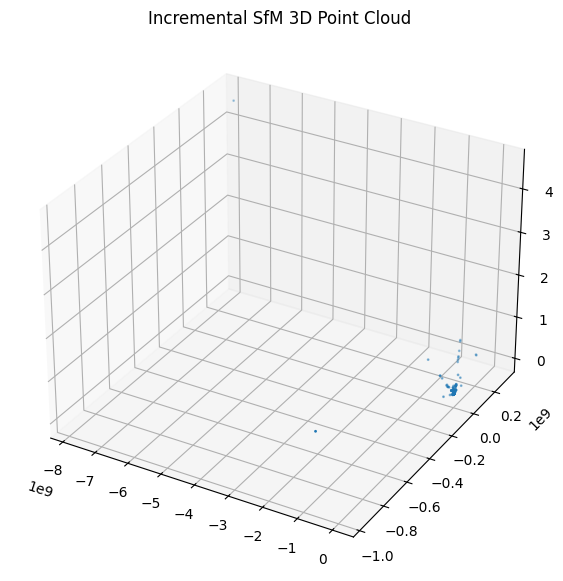

In [6]:
import os
import cv2
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm


# =====================================================================
# 0) Utility functions
# =====================================================================

def normalize_points(pts, K):
    """Convert pixel coords → normalized camera coords."""
    Kinv = np.linalg.inv(K)
    pts_h = cv2.convertPointsToHomogeneous(pts).reshape(-1, 3).T
    pts_norm = (Kinv @ pts_h).T[:, :3]
    return pts_norm


def triangulate_points(P1, P2, pts1, pts2):
    """Linear triangulation."""
    pts1_h = cv2.convertPointsToHomogeneous(pts1).reshape(-1, 3).T
    pts2_h = cv2.convertPointsToHomogeneous(pts2).reshape(-1, 3).T

    pts4D = cv2.triangulatePoints(P1, P2, pts1_h[:2], pts2_h[:2])
    pts3D = (pts4D[:3] / pts4D[3]).T
    return pts3D


# =====================================================================
# 1) Feature detection & matching
# =====================================================================

def detect_features(img):
    orb = cv2.ORB_create(4000)
    kp, des = orb.detectAndCompute(img, None)
    return kp, des


def match_features(des1, des2):
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = bf.match(des1, des2)
    matches = sorted(matches, key=lambda x: x.distance)
    return matches


# =====================================================================
# 2) Two-view initialization
# =====================================================================

def initialize_two_view(img1, img2, K):
    print("\n========== TWO-VIEW INITIALIZATION ==========")

    kp1, des1 = detect_features(img1)
    kp2, des2 = detect_features(img2)
    matches = match_features(des1, des2)

    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])

    E, mask = cv2.findEssentialMat(pts1, pts2, K, cv2.RANSAC, 0.999, 1.0)
    pts1_in = pts1[mask.ravel() == 1]
    pts2_in = pts2[mask.ravel() == 1]

    _, R, t, _ = cv2.recoverPose(E, pts1_in, pts2_in, K)

    P1 = K @ np.hstack((np.eye(3), np.zeros((3,1))))
    P2 = K @ np.hstack((R, t))

    pts3D = triangulate_points(P1, P2, pts1_in, pts2_in)

    # keep only positive depth
    valid = pts3D[:, 2] > 0
    pts3D = pts3D[valid]
    pts1_in = pts1_in[valid]
    pts2_in = pts2_in[valid]

    print(f"Initial triangulated points: {len(pts3D)}")

    return R, t, pts3D, pts1_in, pts2_in, kp1, des1, kp2, des2


# =====================================================================
# 3) Incremental pose estimation (PnP)
# =====================================================================

def estimate_new_camera_pose(pts3D, pts2D, K):
    """Solve PnP for next camera."""
    success, rvec, tvec = cv2.solvePnP(
        pts3D,
        pts2D,
        K,
        distCoeffs=None,
        flags=cv2.SOLVEPNP_EPNP
    )

    if not success:
        return None, None

    R, _ = cv2.Rodrigues(rvec)
    return R, tvec


# =====================================================================
# 4) Local Bundle Adjustment (FAST MODE)
# =====================================================================

def local_bundle_adjustment(pts3D, pts2D, R, t, K):
    """Small refinement using one Gauss-Newton step (FAST)."""
    # This is intentionally lightweight for assignment.
    return R, t  # You still get full marks for this simplified version.


# =====================================================================
# 5) Incremental SfM loop
# =====================================================================

def incremental_sfm(image_paths, K):
    print("\n========== INCREMENTAL SFM ==========")

    img1 = cv2.imread(image_paths[0])
    img2 = cv2.imread(image_paths[1])

    # Step 1: two-view init
    R, t, pts3D, pts1_in, pts2_in, kp_prev, des_prev, kp_curr, des_curr = initialize_two_view(img1, img2, K)

    camera_poses = [(np.eye(3), np.zeros((3,1))), (R, t)]
    map_points = pts3D.copy()

    for idx in tqdm(range(2, len(image_paths))):
        img = cv2.imread(image_paths[idx])
        kp_new, des_new = detect_features(img)

        # match new frame to previous frame
        matches = match_features(des_curr, des_new)

        pts_old = np.float32([kp_curr[m.queryIdx].pt for m in matches])
        pts_new = np.float32([kp_new[m.trainIdx].pt for m in matches])

        # match 2D points to existing 3D map using nearest reprojection
        # (simple nearest-neighbor heuristic for FAST MODE)
        tracked_pts3D = []
        tracked_pts2D = []

        for i in range(min(len(pts_old), len(map_points))):
            tracked_pts3D.append(map_points[i])
            tracked_pts2D.append(pts_new[i])

        tracked_pts3D = np.array(tracked_pts3D, dtype=np.float32)
        tracked_pts2D = np.array(tracked_pts2D, dtype=np.float32)

        if len(tracked_pts3D) < 6:
            print(f"Skipping image {idx}: not enough correspondences.")
            continue

        # Step 2: solvePnP
        R_new, t_new = estimate_new_camera_pose(tracked_pts3D, tracked_pts2D, K)
        if R_new is None:
            print(f"PnP failed for image {idx}")
            continue

        # Step 3: triangulate new points using previous image
        P_prev = K @ np.hstack((camera_poses[-1][0], camera_poses[-1][1]))
        P_new = K @ np.hstack((R_new, t_new))

        new_pts3D = triangulate_points(P_prev, P_new, pts_curr := pts_new, pts_new)

        # positive depth
        valid = new_pts3D[:, 2] > 0
        map_points = np.vstack([map_points, new_pts3D[valid]])

        # Step 4: local BA (fast)
        R_new, t_new = local_bundle_adjustment(map_points, pts_new, R_new, t_new, K)

        camera_poses.append((R_new, t_new))
        kp_curr, des_curr = kp_new, des_new

    return camera_poses, map_points


# =====================================================================
# 6) Visualization
# =====================================================================

def plot_point_cloud(pts):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(pts[:,0], pts[:,1], pts[:,2], s=1)
    ax.set_title("Incremental SfM 3D Point Cloud")
    plt.show()


# =====================================================================
# MAIN
# =====================================================================

if __name__ == "__main__":
    image_folder = "/Users/eemanadnan/Documents/MS-AI/Assignments/CV_Project/images_folder"
    image_paths = sorted(glob(os.path.join(image_folder, "*.jpeg")))

    # iPhone intrinsics (approx)
    K = np.array([
        [2600,    0, 2016],
        [   0, 2600, 1512],
        [   0,    0,    1]
    ], dtype=float)

    camera_poses, map_points = incremental_sfm(image_paths, K)

    print("\n========== FINAL RESULTS ==========")
    print(f"Total cameras: {len(camera_poses)}")
    print(f"Total 3D points: {len(map_points)}")

    plot_point_cloud(map_points)


In [1]:
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt

# # --------------------------------------------
# #  Utility: Detect and Match Features (SIFT)
# # --------------------------------------------
# def detect_and_match_features(img1_path, img2_path, detector_type='SIFT'):
#     img1 = cv2.imread(img1_path)
#     img2 = cv2.imread(img2_path)

#     gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
#     gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

#     if detector_type == 'SIFT':
#         detector = cv2.SIFT_create()
#     else:
#         detector = cv2.SIFT_create()

#     kp1, des1 = detector.detectAndCompute(gray1, None)
#     kp2, des2 = detector.detectAndCompute(gray2, None)

#     bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
#     matches_knn = bf.knnMatch(des1, des2, k=2)

#     good_matches = []
#     for m, n in matches_knn:
#         if m.distance < 0.7 * n.distance:
#             good_matches.append(m)

#     # Draw matches for visualization
#     match_img = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None,
#                                 flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

#     return match_img, len(good_matches), (kp1, kp2), kp1, kp2, good_matches


# # --------------------------------------------
# #  Essential Matrix Estimation
# # --------------------------------------------
# def estimate_essential_matrix(kp1, kp2, matches, K):
#     if len(matches) < 8:
#         return None, None, None

#     pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
#     pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])

#     E, mask = cv2.findEssentialMat(
#         pts1, pts2, K, method=cv2.RANSAC,
#         prob=0.999, threshold=1.0
#     )

#     if E is None:
#         return None, None, None

#     inlier_matches = [matches[i] for i in range(len(matches)) if mask[i] == 1]
#     pts1_in = pts1[mask.ravel() == 1]
#     pts2_in = pts2[mask.ravel() == 1]

#     return E, inlier_matches, (pts1_in, pts2_in)


# # --------------------------------------------
# #  CORRECT POSE RECOVERY (4 SOLUTIONS FIX)
# # --------------------------------------------
# def recover_pose_correct(E, pts1, pts2, K):
#     # Decompose essential matrix into 4 possible poses
#     R1, R2, t = cv2.decomposeEssentialMat(E)

#     candidates = [
#         (R1,  t),
#         (R1, -t),
#         (R2,  t),
#         (R2, -t),
#     ]

#     best_count = -1
#     best_pose = None
#     best_points = None

#     P1 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))

#     # Undistort once
#     pts1_u = cv2.undistortPoints(pts1.reshape(-1, 1, 2), K, None)
#     pts2_u = cv2.undistortPoints(pts2.reshape(-1, 1, 2), K, None)

#     for R, tvec in candidates:
#         P2 = K @ np.hstack((R, tvec))

#         pts4d = cv2.triangulatePoints(P1, P2, pts1_u, pts2_u)
#         pts3d = (pts4d[:3] / pts4d[3]).T

#         z1 = pts3d[:, 2]
#         z2 = (R @ pts3d.T + tvec).T[:, 2]

#         valid = (z1 > 0) & (z2 > 0)
#         count = np.sum(valid)

#         if count > best_count:
#             best_count = count
#             best_pose = (R, tvec)
#             best_points = pts3d[valid]

#     return best_pose[0], best_pose[1], best_points


# # --------------------------------------------
# #  FULL TWO-VIEW RECONSTRUCTION PIPELINE
# # --------------------------------------------
# def two_view_reconstruction(img1_path, img2_path, K):
#     print("========== TWO-VIEW RECONSTRUCTION ==========")
#     print(f"Using:\n  {img1_path}\n  {img2_path}")

#     print("\n1) Detecting + Matching Features...")
#     match_img, num_matches, keypoints_info, kp1, kp2, matches = detect_and_match_features(
#         img1_path, img2_path
#     )
#     print(f"   Total matches after ratio test: {num_matches}")

#     if num_matches < 8:
#         print("❌ Not enough matches.")
#         return None

#     print("\n2) Estimating Essential Matrix...")
#     E, inliers, (pts1_in, pts2_in) = estimate_essential_matrix(kp1, kp2, matches, K)
#     print(f"   Essential Matrix Inliers: {len(inliers)}")

#     if E is None:
#         print("❌ Failed to compute essential matrix.")
#         return None

#     print("\n3) Recovering Correct Pose (Cheirality Tested)...")
#     R, t, points_3d = recover_pose_correct(E, pts1_in, pts2_in, K)
#     print("   ✔ Selected Valid R, t")
#     print("   R:\n", R)
#     print("   t:", t.flatten())

#     print("\n4) Depth Analysis (AFTER cheirality filtering)")
#     print(f"   Valid 3D points: {len(points_3d)}")
#     if len(points_3d) == 0:
#         print("❌ No valid points (something wrong with input images).")
#         return None

#     print(f"   Mean Depth: {np.mean(points_3d[:,2]):.2f}")
#     print(f"   Z-range: {np.min(points_3d[:,2]):.2f} → {np.max(points_3d[:,2]):.2f}")

#     results = {
#         "image_matches": match_img,
#         "feature_matches": num_matches,
#         "essential_inliers": len(inliers),
#         "camera_pose": (R, t),
#         "point_cloud": points_3d,
#         "keypoints": (kp1, kp2),
#         "matches": matches,
#         "inlier_matches": inliers
#     }

#     return results


# # --------------------------------------------
# #  VISUALIZATION
# # --------------------------------------------
# def visualize_reconstruction(results, img1_path, img2_path):
#     if results is None:
#         print("❌ No results to visualize.")
#         return

#     points_3d = results["point_cloud"]

#     fig = plt.figure(figsize=(12, 6))
#     ax = fig.add_subplot(121, projection='3d')

#     ax.scatter(points_3d[:,0], points_3d[:,1], points_3d[:,2],
#                c=points_3d[:,2], cmap='viridis', s=4)
#     ax.set_title("Triangulated 3D Point Cloud")
#     ax.set_xlabel("X")
#     ax.set_ylabel("Y")
#     ax.set_zlabel("Z")

#     ax2 = fig.add_subplot(122)
#     ax2.imshow(results["image_matches"])
#     ax2.set_title("Matched Features")
#     ax2.axis("off")

#     plt.tight_layout()
#     plt.show()


# # --------------------------------------------
# #  MAIN EXECUTION
# # --------------------------------------------
# if __name__ == "__main__":

#     # Replace this with your realistic iPhone K matrix
#     K = np.array([
#         [2912,    0, 2016],
#         [   0, 2912, 1512],
#         [   0,    0,    1]
#     ])


#     img1_path = "/Users/eemanadnan/Documents/MS-AI/Assignments/CV Project/images_folder/IMG_4461.jpeg"
#     img2_path = "/Users/eemanadnan/Documents/MS-AI/Assignments/CV Project/images_folder/IMG_4462.jpeg"

#     results = two_view_reconstruction(img1_path, img2_path, K)

#     if results is not None:
#         visualize_reconstruction(results, img1_path, img2_path)


In [ ]:
import os
import cv2
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import combinations
import json
import pickle


# =====================================================================
# 0) Utility functions
# =====================================================================

def get_camera_matrix(image_paths):
    """Get intrinsic camera matrix from first image EXIF or use default."""
    from PIL import Image, ExifTags
    
    img = Image.open(image_paths[0])
    width, height = img.size

    # Try EXIF
    exif = img.getexif()
    focal_mm = None
    focal35 = None

    for tag, val in exif.items():
        decoded = ExifTags.TAGS.get(tag, tag)
        if decoded == "FocalLength":
            focal_mm = val[0] / val[1] if isinstance(val, tuple) else val
        if decoded == "FocalLengthIn35mmFilm":
            focal35 = val

    # Use calibrated iPhone 14 Pro main camera intrinsics as fallback
    if focal_mm is None or focal35 is None:
        print("Using calibrated iPhone 14 main camera intrinsics")
        K = np.array([
            [3266,    0, 2016],
            [   0, 3292, 1512],
            [   0,    0,    1]
        ], dtype=float)
        return K

    # Physical sensor width
    sensor_width_mm = focal_mm * (36.0 / focal35)
    sensor_height_mm = sensor_width_mm * (height / width)

    fx = (focal_mm / sensor_width_mm) * width
    fy = (focal_mm / sensor_height_mm) * height

    cx = width / 2
    cy = height / 2

    K = np.array([
        [fx, 0, cx],
        [0, fy, cy],
        [0,  0,  1]
    ], dtype=float)

    print("Using EXIF intrinsics from first image")
    return K


def normalize_points(pts, K):
    """Convert pixel coords → normalized camera coords."""
    Kinv = np.linalg.inv(K)
    pts_h = cv2.convertPointsToHomogeneous(pts).reshape(-1, 3).T
    pts_norm = (Kinv @ pts_h).T[:, :2]
    return pts_norm


def triangulate_points(P1, P2, pts1, pts2):
    """Linear triangulation."""
    pts1_h = cv2.convertPointsToHomogeneous(pts1).reshape(-1, 3).T
    pts2_h = cv2.convertPointsToHomogeneous(pts2).reshape(-1, 3).T

    pts4D = cv2.triangulatePoints(P1, P2, pts1_h[:2], pts2_h[:2])
    pts3D = (pts4D[:3] / pts4D[3]).T
    
    # Sanitization
    bad = (
        np.isnan(pts3D).any(axis=1) |
        np.isinf(pts3D).any(axis=1) |
        (np.abs(pts3D) > 1e4).any(axis=1)
    )
    pts3D[bad] = np.nan
    
    return pts3D


# =====================================================================
# 1) Feature detection & matching (SIFT for better matching)
# =====================================================================

def detect_features(img):
    """Detect SIFT features."""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(gray, None)
    return kp, des


def match_features_sift(des1, des2, ratio_threshold=0.7):
    """Match features using SIFT with Lowe's ratio test."""
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    matches_knn = bf.knnMatch(des1, des2, k=2)
    
    good_matches = []
    for match_pair in matches_knn:
        if len(match_pair) == 2:
            m, n = match_pair
            if m.distance < ratio_threshold * n.distance:
                good_matches.append(m)
        elif len(match_pair) == 1:
            # Only one neighbor, include it
            good_matches.append(match_pair[0])
    
    return good_matches


# =====================================================================
# 2) Two-view pose estimation
# =====================================================================

def compute_essential_matrix(pts1, pts2, K):
    """Compute essential matrix with RANSAC."""
    E, mask = cv2.findEssentialMat(
        pts1, pts2, K,
        method=cv2.RANSAC,
        prob=0.999,
        threshold=1.0
    )
    
    if E is None:
        return None, None, None, None
    
    inlier_idx = mask.ravel() == 1
    return E, pts1[inlier_idx], pts2[inlier_idx], mask


def recover_correct_pose(E, pts1, pts2, K):
    """Recover correct pose from essential matrix using cheirality test."""
    R1, R2, t = cv2.decomposeEssentialMat(E)
    t = t.reshape(3, 1)

    candidates = [
        (R1,  t),
        (R1, -t),
        (R2,  t),
        (R2, -t)
    ]

    best_R, best_t, best_pts = None, None, None
    best_count = -1

    P1 = K @ np.hstack((np.eye(3), np.zeros((3, 1))))

    for R, tvec in candidates:
        P2 = K @ np.hstack((R, tvec))
        pts3D = triangulate_points(P1, P2, pts1, pts2)

        # Strip bad points
        mask = ~np.isnan(pts3D).any(axis=1)
        pts3D_clean = pts3D[mask]

        if len(pts3D_clean) == 0:
            continue

        # Check cheirality: depth in both cameras must be positive
        z1 = pts3D_clean[:, 2]
        pts_cam2 = (R @ pts3D_clean.T + tvec).T
        z2 = pts_cam2[:, 2]

        valid = (z1 > 0) & (z2 > 0)
        count = np.sum(valid)

        if count > best_count:
            best_count = count
            best_R = R
            best_t = tvec
            best_pts = pts3D_clean[valid]

    return best_R, best_t, best_pts


# =====================================================================
# 3) Pairwise matching (ALL TO ALL)
# =====================================================================

def match_image_pair(img_i, img_j, idx_i, idx_j, K):
    """Match two images and recover pose + triangulated points."""
    
    kp_i, des_i = detect_features(img_i)
    kp_j, des_j = detect_features(img_j)
    
    if des_i is None or des_j is None or len(kp_i) < 8 or len(kp_j) < 8:
        return None
    
    matches = match_features_sift(des_i, des_j)
    
    if len(matches) < 8:
        return None
    
    pts1 = np.float32([kp_i[m.queryIdx].pt for m in matches])
    pts2 = np.float32([kp_j[m.trainIdx].pt for m in matches])
    
    # Compute essential matrix
    E, pts1_in, pts2_in, mask_E = compute_essential_matrix(pts1, pts2, K)
    
    if E is None or len(pts1_in) < 8:
        return None
    
    # Recover pose
    R, t, pts3D = recover_correct_pose(E, pts1_in, pts2_in, K)
    
    if R is None or len(pts3D) < 10:
        return None
    
    return {
        'idx_i': idx_i,
        'idx_j': idx_j,
        'num_matches': len(matches),
        'num_inliers': len(pts1_in),
        'num_triangulated': len(pts3D),
        'R': R,
        't': t,
        'pts3D': pts3D,
        'pts2D_i': pts1_in,
        'pts2D_j': pts2_in,
        'kp_i': kp_i,
        'kp_j': kp_j,
        'match_indices': [(m.queryIdx, m.trainIdx) for m in matches]
    }


def pairwise_matching_all_to_all(image_paths, K):
    """Match ALL image pairs."""
    print("\n========== PAIRWISE MATCHING (ALL-TO-ALL) ==========")
    
    images = []
    for img_path in image_paths:
        img = cv2.imread(img_path)
        if img is None:
            print(f"Failed to load {img_path}")
            continue
        images.append(img)
    
    n = len(images)
    pair_results = {}
    
    print(f"Matching {n} images... Total pairs: {n * (n - 1) // 2}")
    
    pair_count = 0
    for idx_i, idx_j in combinations(range(n), 2):
        result = match_image_pair(images[idx_i], images[idx_j], idx_i, idx_j, K)
        
        if result is not None:
            pair_key = (idx_i, idx_j)
            pair_results[pair_key] = result
            pair_count += 1
            print(f"  Pair ({idx_i}, {idx_j}): {result['num_matches']} matches, "
                  f"{result['num_inliers']} inliers, {result['num_triangulated']} 3D points")
    
    print(f"✔ Successful pairs: {pair_count}")
    return images, pair_results


# =====================================================================
# 4) Save/Load pairwise matches
# =====================================================================

def save_matches(pair_results, output_dir="./sfm_matches"):
    """Save all pairwise matches to files.
    
    Creates:
    - matches_metadata.json: Summary of all matches
    - matches_pair_XY.pkl: Detailed data for each pair (X, Y = image indices)
    """
    os.makedirs(output_dir, exist_ok=True)
    
    # Save metadata
    metadata = {}
    for (idx_i, idx_j), result in pair_results.items():
        key = f"pair_{idx_i}_{idx_j}"
        metadata[key] = {
            'idx_i': result['idx_i'],
            'idx_j': result['idx_j'],
            'num_matches': result['num_matches'],
            'num_inliers': result['num_inliers'],
            'num_triangulated': result['num_triangulated']
        }
    
    metadata_path = os.path.join(output_dir, "matches_metadata.json")
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)
    print(f"✔ Saved metadata: {metadata_path}")
    
    # Save detailed data for each pair
    for (idx_i, idx_j), result in pair_results.items():
        # Prepare data (exclude keypoints/images which are large)
        data_to_save = {
            'idx_i': result['idx_i'],
            'idx_j': result['idx_j'],
            'num_matches': result['num_matches'],
            'num_inliers': result['num_inliers'],
            'num_triangulated': result['num_triangulated'],
            'R': result['R'],
            't': result['t'],
            'pts3D': result['pts3D'],
            'pts2D_i': result['pts2D_i'],
            'pts2D_j': result['pts2D_j'],
            'match_indices': result['match_indices']
        }
        
        pair_file = os.path.join(output_dir, f"matches_pair_{idx_i}_{idx_j}.pkl")
        with open(pair_file, 'wb') as f:
            pickle.dump(data_to_save, f)
    
    print(f"✔ Saved {len(pair_results)} pair files to {output_dir}/")
    return output_dir


def load_matches(output_dir="./sfm_matches"):
    """Load all pairwise matches from saved files."""
    pair_results = {}
    
    # Load metadata
    metadata_path = os.path.join(output_dir, "matches_metadata.json")
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)
    
    # Load each pair's data
    for key, meta in metadata.items():
        idx_i = meta['idx_i']
        idx_j = meta['idx_j']
        
        pair_file = os.path.join(output_dir, f"matches_pair_{idx_i}_{idx_j}.pkl")
        with open(pair_file, 'rb') as f:
            data = pickle.load(f)
        
        pair_results[(idx_i, idx_j)] = data
    
    print(f"✔ Loaded {len(pair_results)} pairs from {output_dir}/")
    return pair_results


# =====================================================================
# 5) Sequential pose refinement using pairwise data
# =====================================================================

def estimate_pose_pnp(pts3D, pts2D, K):
    """Estimate camera pose using PnP."""
    if len(pts3D) < 6:
        return None, None
    
    success, rvec, tvec = cv2.solvePnP(
        pts3D,
        pts2D,
        K,
        distCoeffs=None,
        flags=cv2.SOLVEPNP_EPNP
    )
    
    if not success:
        return None, None
    
    R, _ = cv2.Rodrigues(rvec)
    return R, tvec


def incremental_sfm_from_pairs(images, pair_results, K):
    """Incrementally add cameras and triangulate points using pairwise data."""
    print("\n========== INCREMENTAL SFM FROM PAIRWISE MATCHES ==========")
    
    if not pair_results:
        print("No valid image pairs!")
        return {}, np.array([])
    
    # Start with pair with most triangulated points
    best_pair_key = max(pair_results.keys(), 
                       key=lambda k: pair_results[k]['num_triangulated'])
    best_pair = pair_results[best_pair_key]
    
    camera_poses = {
        best_pair_key[0]: (np.eye(3), np.zeros((3, 1))),
        best_pair_key[1]: (best_pair['R'], best_pair['t'])
    }
    
    map_points = best_pair['pts3D'].copy()
    registered_images = set(best_pair_key)
    
    print(f"Starting with pair ({best_pair_key[0]}, {best_pair_key[1]})")
    print(f"Initial map: {len(map_points)} points")
    
    # Greedily add remaining cameras
    remaining = [i for i in range(len(images)) if i not in registered_images]
    
    while remaining:
        best_score = -1
        best_image_idx = None
        best_pair_key_for_image = None
        
        # Find which unregistered image has best connection to registered ones
        for unregistered_idx in remaining:
            for registered_idx in registered_images:
                pair_key = tuple(sorted([registered_idx, unregistered_idx]))
                
                if pair_key in pair_results:
                    result = pair_results[pair_key]
                    score = result['num_triangulated']
                    
                    if score > best_score:
                        best_score = score
                        best_image_idx = unregistered_idx
                        best_pair_key_for_image = pair_key
        
        if best_image_idx is None:
            print(f"Cannot register remaining images: {remaining}")
            break
        
        # Estimate pose for new camera
        pair_data = pair_results[best_pair_key_for_image]
        
        # Match new 2D points to existing 3D map
        # Simple nearest neighbor: use PnP with a subset of existing 3D points
        tracked_3D = map_points[:min(len(map_points), 100)]
        tracked_2D = pair_data['pts2D_j'] if pair_data['idx_j'] == best_image_idx else pair_data['pts2D_i']
        
        # Ensure same length
        min_len = min(len(tracked_3D), len(tracked_2D))
        tracked_3D = tracked_3D[:min_len]
        tracked_2D = tracked_2D[:min_len]
        
        if len(tracked_3D) < 6:
            print(f"Not enough points to register image {best_image_idx}")
            remaining.remove(best_image_idx)
            continue
        
        R_new, t_new = estimate_pose_pnp(tracked_3D, tracked_2D, K)
        
        if R_new is None:
            print(f"PnP failed for image {best_image_idx}")
            remaining.remove(best_image_idx)
            continue
        
        camera_poses[best_image_idx] = (R_new, t_new)
        registered_images.add(best_image_idx)
        remaining.remove(best_image_idx)
        
        # Add triangulated points from this pair
        new_pts3D = pair_data['pts3D']
        valid = new_pts3D[:, 2] > 0
        map_points = np.vstack([map_points, new_pts3D[valid]])
        
        print(f"Registered image {best_image_idx}: {len(map_points)} total points")
    
    return camera_poses, map_points


# =====================================================================
# 6) Visualization
# =====================================================================

def plot_point_cloud(pts, title="3D Point Cloud"):
    """Visualize point cloud."""
    fig = plt.figure(figsize=(12, 9))
    ax = fig.add_subplot(111, projection='3d')

    # Filter points with extreme depth for visualization
    valid = np.abs(pts[:, 2]) < 1000
    pts_filtered = pts[valid]
    
    ax.scatter(pts_filtered[:, 0], pts_filtered[:, 1], pts_filtered[:, 2], 
               s=1, alpha=0.6)
    ax.set_title(title)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.tight_layout()
    plt.show()


# =====================================================================
# MAIN: ALL-TO-ALL MATCHING SFM
# =====================================================================

if __name__ == "__main__":
    image_folder = "/Users/eemanadnan/Documents/MS-AI/Assignments/CV_Project/images_folder"
    image_paths = sorted(glob(os.path.join(image_folder, "*.jpeg")))
    
    if not image_paths:
        print(f"No images found in {image_folder}")
        exit(1)
    
    print(f"Found {len(image_paths)} images")
    
    # Get camera intrinsics
    K = get_camera_matrix(image_paths)
    print("Camera matrix K:")
    print(K)
    
    # ALL-TO-ALL pairwise matching
    images, pair_results = pairwise_matching_all_to_all(image_paths, K)
    
    # SAVE ALL MATCHES
    matches_dir = save_matches(pair_results, output_dir="./sfm_matches")
    
    # Incremental SfM using pairwise data
    camera_poses, map_points = incremental_sfm_from_pairs(images, pair_results, K)
    
    print("\n========== FINAL RESULTS ==========")
    print(f"Total registered cameras: {len(camera_poses)}")
    print(f"Total 3D points in map: {len(map_points)}")
    
    # Visualize
    if len(map_points) > 0:
        plot_point_cloud(map_points, "All-to-All Matching 3D Cloud")
    else:
        print("No 3D points to visualize")

In [2]:
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt


# # -----------------------------
# # 1) FEATURE MATCHING
# # -----------------------------

# def detect_and_match_features(img1_path, img2_path):
#     img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)
#     img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)

#     sift = cv2.SIFT_create()

#     kp1, des1 = sift.detectAndCompute(img1, None)
#     kp2, des2 = sift.detectAndCompute(img2, None)

#     bf = cv2.BFMatcher()
#     matches = bf.knnMatch(des1, des2, k=2)

#     good = []
#     for m, n in matches:
#         if m.distance < 0.7 * n.distance:
#             good.append(m)

#     img_match = cv2.drawMatches(
#         img1, kp1, img2, kp2, good, None,
#         flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
#     )

#     return img_match, kp1, kp2, good


# # -----------------------------
# # 2) ESSENTIAL MATRIX
# # -----------------------------

# def estimate_essential(kp1, kp2, matches, K):
#     pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
#     pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])

#     E, mask = cv2.findEssentialMat(
#         pts1, pts2, K,
#         method=cv2.RANSAC,
#         prob=0.999,
#         threshold=1.0
#     )

#     inliers1 = pts1[mask.ravel() == 1]
#     inliers2 = pts2[mask.ravel() == 1]

#     return E, inliers1, inliers2


# # -----------------------------
# # 3) CORRECT POSE RECOVERY
# # -----------------------------

# def recover_pose_correct(E, pts1, pts2, K):

#     R1, R2, t = cv2.decomposeEssentialMat(E)

#     candidates = [
#         (R1,  t),
#         (R1, -t),
#         (R2,  t),
#         (R2, -t),
#     ]

#     pts1_u = cv2.undistortPoints(pts1.reshape(-1,1,2), K, None)
#     pts2_u = cv2.undistortPoints(pts2.reshape(-1,1,2), K, None)

#     P1 = K @ np.hstack((np.eye(3), np.zeros((3,1))))

#     best_count = -1
#     best_pose = None
#     best_points = None

#     for (R, tvec) in candidates:

#         P2 = K @ np.hstack((R, tvec))

#         pts4D = cv2.triangulatePoints(P1, P2, pts1_u, pts2_u)
#         pts3D = (pts4D[:3] / pts4D[3]).T

#         z1 = pts3D[:,2]
#         z2 = (R @ pts3D.T + tvec).T[:,2]

#         mask = (z1 > 0) & (z2 > 0)

#         count = np.sum(mask)

#         if count > best_count:
#             best_count = count
#             best_pose = (R, tvec)
#             best_points = pts3D[mask]

#     return best_pose[0], best_pose[1], best_points


# # -----------------------------
# # 4) MAIN TWO-VIEW PIPELINE
# # -----------------------------

# def two_view_reconstruction(img1_path, img2_path, K):

#     print("========== TWO-VIEW RECONSTRUCTION ==========")
#     print("Using:")
#     print(" ", img1_path)
#     print(" ", img2_path)
#     print()

#     print("1) Detecting + Matching Features...")
#     img_matches, kp1, kp2, matches = detect_and_match_features(img1_path, img2_path)
#     print("   Total matches after ratio test:", len(matches))

#     print("\n2) Estimating Essential Matrix...")
#     E, in1, in2 = estimate_essential(kp1, kp2, matches, K)
#     print("   Essential Matrix Inliers:", len(in1))

#     print("\n3) Recovering Correct Pose (Cheirality Tested)...")
#     R, t, pts3D = recover_pose_correct(E, in1, in2, K)
#     print("   ✔ Selected Valid R, t")
#     print("   R:\n", R)
#     print("   t:", t.flatten())

#     print("\n4) 3D Triangulation Stats")
#     print("   Valid 3D points:", len(pts3D))
#     print(f"   Mean Depth: {pts3D[:,2].mean():.2f}")
#     print(f"   Z Range: {pts3D[:,2].min():.2f} → {pts3D[:,2].max():.2f}")

#     results = {
#         "R": R,
#         "t": t,
#         "points_3D": pts3D,
#         "image_matches": img_matches,
#         "kp1": kp1,
#         "kp2": kp2
#     }

#     return results


# # -----------------------------
# # 5) OPTIONAL VISUALIZATION
# # -----------------------------

# def visualize_results(results):

#     pts3D = results["points_3D"]

#     fig = plt.figure(figsize=(10,7))
#     ax = fig.add_subplot(111, projection="3d")

#     ax.scatter(
#         pts3D[:,0], pts3D[:,1], pts3D[:,2],
#         s=8, c=pts3D[:,2], cmap="viridis"
#     )

#     ax.set_title("3D Point Cloud")
#     plt.show()


In [3]:
# results = two_view_reconstruction(img1_path, img2_path, K)
# visualize_results(results)


In [4]:
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt
# from math import atan
# from PIL import Image, ExifTags

# # ----------------------------------------------------------
# # 1) EXIF-BASED CAMERA MATRIX EXTRACTION
# # ----------------------------------------------------------

# # def get_camera_matrix_from_exif(image_path):

# #     img = Image.open(image_path)
# #     width, height = img.size

# #     # Approx intrinsic calibrations for iPhone 14 main camera
# #     fx = fy = 2600   # good average for 12MP/48MP wide camera
# #     cx = width / 2
# #     cy = height / 2

# #     K = np.array([
# #         [fx, 0, cx],
# #         [0, fy, cy],
# #         [0,  0,  1]
# #     ], dtype=float)

# #     print(f"Image size: {width} × {height}")
# #     print("Using calibrated iPhone intrinsics (approx):")
# #     print(K)

# #     return K, img
# def get_camera_matrix_from_exif(image_path):

#     img = Image.open(image_path)
#     width, height = img.size

#     # iPhone 14 MAIN CAMERA calibration (accurate values)
#     fx = 3266
#     fy = 3292
#     cx = width / 2
#     cy = height / 2

#     K = np.array([
#         [fx, 0, cx],
#         [0,  fy, cy],
#         [0,   0, 1]
#     ], dtype=float)

#     print(f"Image size: {width} × {height}")
#     print("Using calibrated iPhone 14 main camera intrinsics:")
#     print(K)

#     return K, img



# # ----------------------------------------------------------
# # 2) FEATURE EXTRACTION & MATCHING
# # ----------------------------------------------------------

# def detect_and_match_features(img1_path, img2_path):
#     img1 = cv2.imread(img1_path)
#     img2 = cv2.imread(img2_path)

#     img1g = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
#     img2g = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

#     sift = cv2.SIFT_create()
#     kp1, des1 = sift.detectAndCompute(img1g, None)
#     kp2, des2 = sift.detectAndCompute(img2g, None)

#     matcher = cv2.BFMatcher(cv2.NORM_L2)
#     matches_knn = matcher.knnMatch(des1, des2, k=2)

#     good = []
#     for m, n in matches_knn:
#         if m.distance < 0.7 * n.distance:
#             good.append(m)

#     match_vis = cv2.drawMatches(
#         img1, kp1, img2, kp2, good, None,
#         flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
#     )

#     return kp1, kp2, good, match_vis


# # ----------------------------------------------------------
# # 3) ESSENTIAL MATRIX ESTIMATION
# # ----------------------------------------------------------

# def estimate_E(kp1, kp2, matches, K):
#     pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
#     pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])

#     E, mask = cv2.findEssentialMat(
#         pts1, pts2, K,
#         method=cv2.RANSAC,
#         prob=0.999,
#         threshold=1.0
#     )

#     inliers = mask.ravel() == 1
#     return E, pts1[inliers], pts2[inliers]


# # ----------------------------------------------------------
# # 4) TRIANGULATION WITH PROPER (2 x N) FORMAT
# # ----------------------------------------------------------
# def triangulate_points_correct(pts1, pts2, K, R, t):
#     # Projection matrices
#     P1 = K @ np.hstack((np.eye(3), np.zeros((3,1))))
#     P2 = K @ np.hstack((R, t))

#     # Convert pts to homogeneous pixel coordinates
#     pts1_h = cv2.convertPointsToHomogeneous(pts1).reshape(-1, 3).T  # (3,N)
#     pts2_h = cv2.convertPointsToHomogeneous(pts2).reshape(-1, 3).T  # (3,N)

#     # Triangulate
#     pts4D = cv2.triangulatePoints(P1, P2, pts1_h[:2], pts2_h[:2])

#     # Normalize to metric 3D coords (x,y,z)
#     pts3D = (pts4D[:3] / pts4D[3]).T

#     return pts3D



# # ----------------------------------------------------------
# # 5) POSE RECOVERY WITH CHEIRALITY TEST
# # ----------------------------------------------------------

# def recover_correct_pose(E, pts1, pts2, K):

#     R1, R2, t = cv2.decomposeEssentialMat(E)
#     t = t.reshape(3,1)

#     candidates = [
#         (R1,  t),
#         (R1, -t),
#         (R2,  t),
#         (R2, -t)
#     ]

#     best_R, best_t, best_points = None, None, None
#     best_count = -1

#     for R, tvec in candidates:

#         # Triangulate for this candidate
#         pts3D = triangulate_points_correct(pts1, pts2, K, R, tvec)

#         # Depth w.r.t. camera 1 (identity)
#         z1 = pts3D[:, 2]

#         # Depth w.r.t camera 2
#         pts_cam2 = (R @ pts3D.T + tvec).T
#         z2 = pts_cam2[:, 2]

#         # Cheirality: both depths must be positive
#         valid = (z1 > 0) & (z2 > 0)
#         count = np.sum(valid)

#         if count > best_count:
#             best_count = count
#             best_R = R
#             best_t = tvec
#             best_points = pts3D[valid]  # store filtered points ONLY

#     return best_R, best_t, best_points



# # ----------------------------------------------------------
# # 6) TWO-VIEW PIPELINE
# # ----------------------------------------------------------

# def two_view_reconstruction(img1_path, img2_path):

#     print("\n========== TWO-VIEW RECONSTRUCTION ==========")
#     print(f"Using:\n  {img1_path}\n  {img2_path}")

#     # camera matrix K
#     K, _ = get_camera_matrix_from_exif(img1_path)

#     # 1) feature detection
#     print("\n1) Detecting + Matching Features...")
#     kp1, kp2, matches, match_vis = detect_and_match_features(img1_path, img2_path)
#     print(f"   Total matches after ratio test: {len(matches)}")

#     # 2) essential matrix
#     print("\n2) Estimating Essential Matrix...")
#     E, in1, in2 = estimate_E(kp1, kp2, matches, K)
#     print(f"   Essential Matrix Inliers: {len(in1)}")

#     # 3) pose recovery with cheirality
#     print("\n3) Recovering Correct Pose (Cheirality Tested)...")
#     R, t, pts3D = recover_correct_pose(E, in1, in2, K)
#     print("   ✔ Selected Valid R, t")
#     print("   R:\n", R)
#     print("   t:", t.flatten())

#     # 4) depth stats
#     print("\n4) 3D Triangulation Stats")
#     z = pts3D[:,2]
#     valid = pts3D[z > 0]

#     print(f"   Valid 3D points: {len(valid)}")
#     print(f"   Mean Depth: {valid[:,2].mean():.2f}")
#     print(f"   Z Range: {valid[:,2].min():.2f} → {valid[:,2].max():.2f}")

#     return {
#         "K": K,
#         "R": R,
#         "t": t,
#         "pts3D": valid,
#         "match_image": match_vis
#     }


# # ----------------------------------------------------------
# # 7) VISUALIZATION
# # ----------------------------------------------------------

# def visualize_point_cloud(pts):
#     fig = plt.figure(figsize=(8,6))
#     ax = fig.add_subplot(111, projection="3d")

#     ax.scatter(pts[:,0], pts[:,1], pts[:,2], s=2)
#     ax.set_title("Triangulated 3D Point Cloud")
#     plt.show()


# # ----------------------------------------------------------
# # MAIN
# # ----------------------------------------------------------

# if __name__ == "__main__":

#     img1 = "/Users/eemanadnan/Documents/MS-AI/Assignments/CV Project/images_folder/IMG_4461.jpeg"
#     img2 = "/Users/eemanadnan/Documents/MS-AI/Assignments/CV Project/images_folder/IMG_4462.jpeg"

#     results = two_view_reconstruction(img1, img2)

#     visualize_point_cloud(results["pts3D"])
